In [1]:
%pip install sympy


Note: you may need to restart the kernel to use updated packages.


<h2>Importación</h2>

In [2]:
import numpy as np
import math
import ansys.math.core.math as pymath
import sympy
import subprocess
import os 
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

<h1>->Optimización de silueta NACA 2412 </h>

<h2>1. Ingreso de coordenadas [x,y] para extrados e intrados</h2>

Nota: Se elimino el valor de conexión entre extrados e intrados [0,0]

-> Extrados

In [3]:
xe=[1.0000, 0.975752, 0.795047, 0.500587, 0.203313, 0.022051]
ye=[0.00000, 0.005092,0.03776, 0.0723030, 0.072945, 0.028152]
print("xe","\t","ye")
matrix_length = len(xe)
for i in range(matrix_length):
    print(f"{xe[i]:.3f}","\t",f"{ye[i]:.3f}") 

xe 	 ye
1.000 	 0.000
0.976 	 0.005
0.795 	 0.038
0.501 	 0.072
0.203 	 0.073
0.022 	 0.028


-> Intrados

In [4]:
xi=[0.026892, 0.208902,0.499413,0.792738,0.975305,1]
yi=[-0.023408,-0.042343,-0.033414,-0.014999,-0.001896,0]
print("xi","\t","yi")
matrix_length = len(xi)
for i in range(matrix_length):
    print(f"{xi[i]:.3f}","\t",f"{yi[i]:.3f}") 

xi 	 yi
0.027 	 -0.023
0.209 	 -0.042
0.499 	 -0.033
0.793 	 -0.015
0.975 	 -0.002
1.000 	 0.000


<h2>2. Sistema de ecuaciones para encontrar los coeficientes "a" del extrados e intrados</h2>

->Extrados

In [5]:
A = np.array([[pow(xe[j], i + 0.5) for i in range(0, 6)] for j in range(0, 6)])
b = np.array(ye)
sol_e = np.linalg.solve(A, b)
print(sol_e)

[ 0.19191681 -0.09903084 -0.3222481   0.44879009 -0.2805838   0.06115584]


-> Intrados

In [6]:
A = np.array([[pow(xi[j], i + 0.5) for i in range(0, 6)] for j in range(0, 6)])
b = np.array(yi)
sol_i = np.linalg.solve(A, b)
print(sol_i)

[-0.15287633  0.39382672 -0.65334572  0.82318861 -0.57512754  0.16433426]


<h2>NOTA: aquí se verifican los resultados posteriores para y"emáx, y"imin, x_emax & x_imin

-> Calcular X_emax 


In [7]:
xee = sympy.symbols('xee')
fe = sum(sol_e[i]*xee**(i + 0.5) for i in range(0, 6))

dy = sympy.diff(fe, xee)

sol = sympy.solve(dy, xee)

def is_sol(xee):
    if sympy.im(xee) != 0:
        return False
    if xee < 0 or xee > 1:
        return False
    return True

x_eemax =float([xee for xee in sol if is_sol(xee)][0])
print("x_eemax=",x_eemax)
display(fe)

x_eemax= 0.3360826350308561


0.191916805800967*xee**0.5 - 0.0990308397506673*xee**1.5 - 0.322248096918326*xee**2.5 + 0.448790093670569*xee**3.5 - 0.280583798608767*xee**4.5 + 0.0611558358062234*xee**5.5

-> Calcular X_imax 

In [8]:
xii = sympy.symbols('xii')
fi = sum(sol_i[i]*xii**(i + 0.5) for i in range(0, 6))

dy = sympy.diff(fi, xii)

sol = sympy.solve(dy, xii)

def is_sol(xii):
    if sympy.im(xii) != 0:
        return False
    if xii < 0 or xii > 1:
        return False
    return True

x_imin = float([xii for xii in sol if is_sol(xii)][0])
print("x_imin=",x_imin)
display(fi)



x_imin= 0.22236238785873258


-0.152876334737036*xii**0.5 + 0.393826724895681*xii**1.5 - 0.653345724088194*xii**2.5 + 0.823188610271216*xii**3.5 - 0.57512753609923*xii**4.5 + 0.164334259757563*xii**5.5

<h2>3. Calculo de los parametros del perfil<\h2>

-> Variables simbolicas, no son numeros

In [9]:
y_emax, y_imax, alpha, beta, y_bs, deltay_bs, x_emax, x_imax, dy_emax, dy_imax, r_ba=sympy.symbols("y_emax, y_imax, alpha, beta, y_bs, deltay_bs, x_emax,x_imax, dy_emax, dy_imax, r_ba")

In [10]:
ae=sympy.symbols("ae:6")
ai=sympy.symbols("ai:6")


-> Iteradores

In [11]:
k=sympy.symbols("k",integer=True)

-> Ecuaciones a resolver

In [12]:
eq1=sympy.sqrt(2*r_ba)+ai[0]
#extrados
eq2 =sum([ae[k-1]*pow(x_emax, k-0.5) for k in range(1, 7)])-y_emax
eq3=sum([(k-0.5)*ae[k-1]*pow(x_emax, k-1.5) for k in range(1, 7)])
eq4=sum([(k-1.5)*(k-0.5)*ae[k-1]*pow(x_emax, k-2.5) for k in range(1, 7)])-dy_emax
eq5=sum([ae[k-1] for k in range(1, 7)])-y_bs-0.5*deltay_bs    #ybs+deltaybs esto tiene que ser 0 porque se encuentra la punta cerrada y conectada en el eje x
eq6=sum([(k-0.5)*ae[k-1] for k in range(1, 7)])-sympy.tan((2*alpha-beta)/2)
#intrados 
eq7=sum([ai[k-1]*pow(x_imax, k-0.5) for k in range(1, 7)])-y_imax
eq8=sum([(k-0.5)*ai[k-1]*pow(x_imax, k-1.5) for k in range(1, 7)])
eq9=sum([(k-1.5)*(k-0.5)*ai[k-1]*pow(x_imax, k-2.5) for k in range(1, 7)])-dy_imax
eq10=sum([ai[k-1] for k in range(1, 7)])-y_bs-0.5*deltay_bs   #ybs+deltaybs esto tiene que ser 0 porque se encuentra la punta cerrada y conectada en el eje x
eq11=sum([(k-0.5)*ai[k-1] for k in range(1, 7)])-sympy.tan((2*alpha+beta)/2)
#Fueron igualadas a 0 para crear el sistema de solución con ayuda de sympy

-> Impresión y verificación 

In [13]:
display(eq1)
display(eq2)
display(eq3)
display(eq4)
display(eq5)
display(eq6)
display(eq7)
display(eq8)
display(eq9)
display(eq10)
display(eq11)

ai0 + sqrt(2)*sqrt(r_ba)

ae0*x_emax**0.5 + ae1*x_emax**1.5 + ae2*x_emax**2.5 + ae3*x_emax**3.5 + ae4*x_emax**4.5 + ae5*x_emax**5.5 - y_emax

0.5*ae0/x_emax**0.5 + 1.5*ae1*x_emax**0.5 + 2.5*ae2*x_emax**1.5 + 3.5*ae3*x_emax**2.5 + 4.5*ae4*x_emax**3.5 + 5.5*ae5*x_emax**4.5

-0.25*ae0/x_emax**1.5 + 0.75*ae1/x_emax**0.5 + 3.75*ae2*x_emax**0.5 + 8.75*ae3*x_emax**1.5 + 15.75*ae4*x_emax**2.5 + 24.75*ae5*x_emax**3.5 - dy_emax

ae0 + ae1 + ae2 + ae3 + ae4 + ae5 - 0.5*deltay_bs - y_bs

0.5*ae0 + 1.5*ae1 + 2.5*ae2 + 3.5*ae3 + 4.5*ae4 + 5.5*ae5 - tan(alpha - beta/2)

ai0*x_imax**0.5 + ai1*x_imax**1.5 + ai2*x_imax**2.5 + ai3*x_imax**3.5 + ai4*x_imax**4.5 + ai5*x_imax**5.5 - y_imax

0.5*ai0/x_imax**0.5 + 1.5*ai1*x_imax**0.5 + 2.5*ai2*x_imax**1.5 + 3.5*ai3*x_imax**2.5 + 4.5*ai4*x_imax**3.5 + 5.5*ai5*x_imax**4.5

-0.25*ai0/x_imax**1.5 + 0.75*ai1/x_imax**0.5 + 3.75*ai2*x_imax**0.5 + 8.75*ai3*x_imax**1.5 + 15.75*ai4*x_imax**2.5 + 24.75*ai5*x_imax**3.5 - dy_imax

ai0 + ai1 + ai2 + ai3 + ai4 + ai5 - 0.5*deltay_bs - y_bs

0.5*ai0 + 1.5*ai1 + 2.5*ai2 + 3.5*ai3 + 4.5*ai4 + 5.5*ai5 - tan(alpha + beta/2)

<h2>->Simplificación con suposición

In [14]:
eq=[eq1, eq2,  eq4 , eq6, eq7, eq9, eq11] #Se crea un grupo para todas las ecuaciones, NOTA SE ELIMINA 3,5,8, 10 PORQUE VALEN 0!!!!
for i in range(len(eq)):
    for j in range(len(sol_e)):
        eq[i]=eq[i].subs(ae[j],sol_e[j])
    for j in range(len(sol_i)):
        eq[i]=eq[i].subs(ai[j],sol_i[j])
    eq[i]=eq[i].subs({ 'x_emax':x_eemax, 'x_imax':x_imin, 'deltay_bs':0, 'y_bs':0 }) #con derivadas se determina rapidamente estos valores para ayudar al solver

for e in eq:
    display(e) #todo esta igualado a cero

sqrt(2)*sqrt(r_ba) - 0.152876334737036

0.0788166401285028 - y_emax

-dy_emax - 0.565890153534551

-tan(alpha - beta/2) - 0.213712767979562

-y_imax - 0.0423807463583142

0.400692253040476 - dy_imax

0.0778622619238377 - tan(alpha + beta/2)

<h2>->Solver </h2>

In [15]:
def sistema_ecuaciones(x):
    eqv = list(map(lambda eq: float(eq.subs({  #programación funcional 
       'r_ba': x[0],
       'y_emax': x[1],
       'dy_emax': x[2],
       'alpha': x[3],
       'beta':x[5],
       'dy_imax': x[6],
       'y_imax':x[4]
    })),eq))

    return eqv


In [16]:
# Valores iniciales para las variables
x0 = np.zeros(len(eq))

# Resolver el sistema de ecuaciones
solucion = fsolve(sistema_ecuaciones, x0)

# Mostrar las soluciones aproximadas
print("Soluciones aproximadas:")
for i in solucion:
  print("%.4f" % i)


Soluciones aproximadas:
0.0117
0.0788
-0.5659
-0.0664
-0.0424
0.2883
0.4007


In [17]:
sol=np.array([*solucion]) #sprad operador de esparcir 


In [18]:
def generate_combi():
    for i in range(80, 120):
        for j in range(80, 120):
            for k in range(80, 120):
                yield [i, j, k]

gen = generate_combi()

print(next(gen))
print(next(gen))
print(next(gen))

[80, 80, 80]
[80, 80, 81]
[80, 80, 82]


In [19]:
def evalue_combi(i,j,k):
    i, j, k = i / 100, j/100, k/100
    sol[2]=solucion[2]*i
    sol[3]=solucion[3]*j
    sol[6]=solucion[6]*k
    eq1=[1.0,0,0,0,0,0]
    #extrados
    eq2 =[pow(x_eemax, k-0.5) for k in range(1, 7)]
    eq3=[(k-0.5)*pow(x_eemax, k-1.5) for k in range(1, 7)]
    eq4=[(k-1.5)*(k-0.5)*pow(x_eemax, k-2.5) for k in range(1, 7)]
    eq5=[1 for k in range(1, 7)]  #ybs+deltaybs esto tiene que ser 0 porque se encuentra la punta cerrada y conectada en el eje x
    eq6=[(k-0.5) for k in range(1, 7)]
    #intrados 
    eq7=[pow(x_imin, k-0.5) for k in range(1, 7)]
    eq8=[(k-0.5)*pow(x_imin, k-1.5) for k in range(1, 7)]
    eq9=[(k-1.5)*(k-0.5)*pow(x_imin, k-2.5) for k in range(1, 7)]
    eq10=[1 for k in range(1, 7)] #ybs+deltaybs esto tiene que ser 0 porque se encuentra la punta cerrada y conectada en el eje x
    eq11=[(k-0.5) for k in range(1, 7)]
    eq12=[-1.0,0,0,0,0,0]

    ve=[math.sqrt(2*sol[0]),sol[1],0,sol[2],0,math.tan((2*sol[3]-sol[5])/2)]
    vi=[sol[4],0,sol[6],0,math.tan((2*sol[3]+sol[5])/2),math.sqrt(2*sol[0])]     
    Ae=[eq1,eq2,eq3,eq4,eq5,eq6]
    Ai=[eq7,eq8,eq9,eq10,eq11,eq12]
    vi
    sole=np.linalg.solve(Ae,ve)

    soli=np.linalg.solve(Ai,vi)

    return(sole, soli)

In [81]:
def get_coord_combi(i,j,k):
    sole,soli=evalue_combi(i,j,k)
    x=np.arange(0,1,0.01)
    fee = sum(sole[i]*x**(i + 0.5) for i in range(0, 6))
    fii = sum(soli[i]*x**(i + 0.5) for i in range(0, 6))
    xx=[*x[::-1],*x]
    yy=[*fee[::-1],*fii]
    return(xx,yy)



In [82]:
def plot_combi(i,j,k):
    xx,yy=get_coord_combi(i,j,k)
    plt.plot(xx,yy)


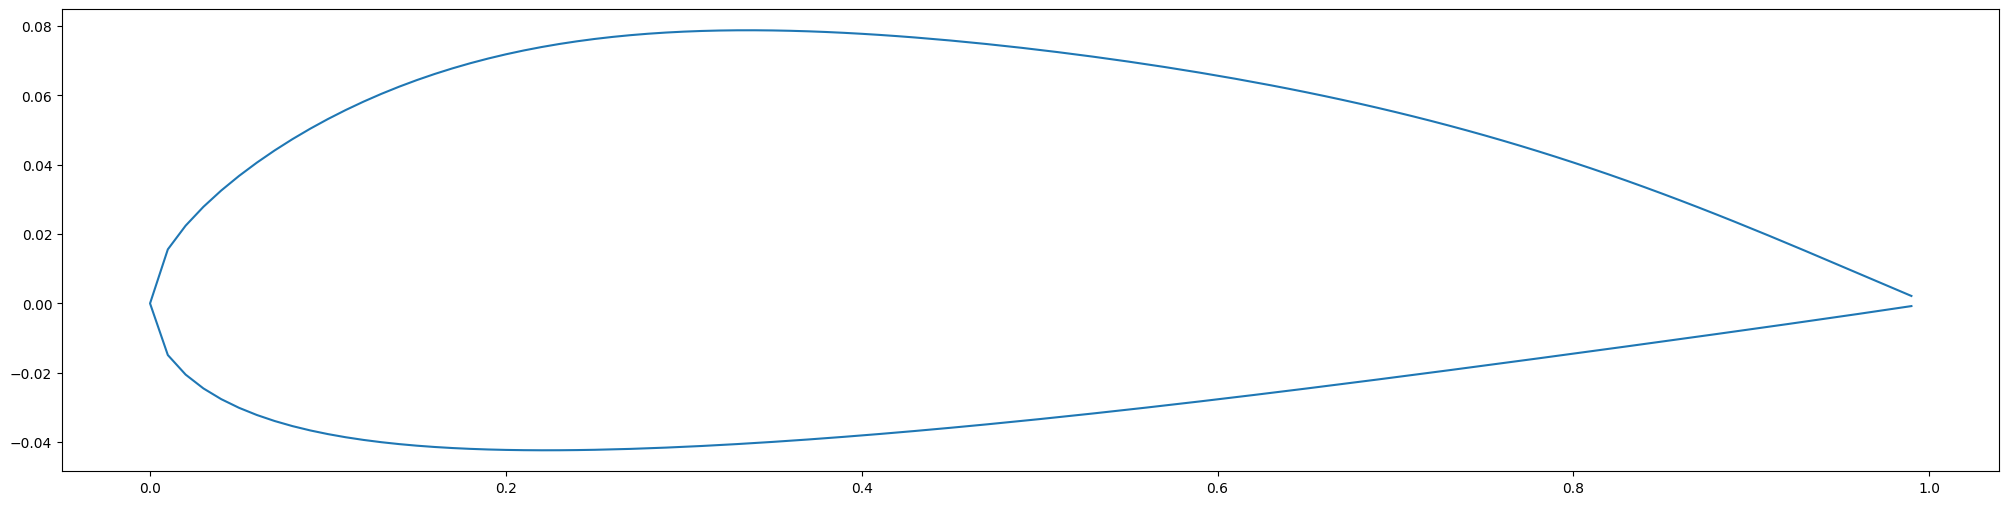

In [83]:
plt.figure(figsize=(25,6))
plot_combi(100,100,100)


In [85]:
def create_coord_file(xx,yy,fname):
    test_result=""
    for i in range(len(xx)):
        x=xx[i]
        y=yy[i]
        test_result += f"{x:.6f}" + (" "*(4 if y >= 0 else 3)) + f"{y:.6f}\n"
    test_result
    file=open(fname + ".dat","w")
    file.write(test_result)
    file.close()

In [86]:

def run_simulation(i,j,k):
    xx,yy=get_coord_combi(i,j,k)
    fname=f"sim_{i}_{j}_{k}"
    create_coord_file(xx,yy,fname)
    strname = str(fname) + '.txt'
    airfoil_name = fname
    alpha_i = 0
    alpha_f = 1
    alpha_step = 1
    Re = 1000000
    n_iter = 100

    # %% XFOIL input file writer 

    if os.path.exists(strname):
        os.remove(strname)

    input_file = open(fname+".in", 'w')
    input_file.write("LOAD {0}.dat\n".format(airfoil_name))
    input_file.write(airfoil_name + '\n')
    input_file.write("PANE\n")
    input_file.write("OPER\n")
    input_file.write("Visc {0}\n".format(Re))
    input_file.write("PACC\n")
    input_file.write(strname+"\n\n ")
    input_file.write("ITER {0}\n".format(n_iter))
    input_file.write("ASeq {0} {1} {2}\n".format(alpha_i, alpha_f,
                                                alpha_step))
    input_file.write("\n\n")
    input_file.write("quit\n")
    input_file.close()

    subprocess.call("xfoil.exe < "+fname+".in", shell=True)

In [87]:
run_simulation(100,100,100)